In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import theilslopes
import pymannkendall as mk  # pip install pymannkendall

In [2]:
pip install pymannkendall

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# Load your data into a DataFrame. Here, we assume your CSV has a "Year" column.
df = pd.read_csv('suitable_polys_with_79_2019_monthly_data_0.csv')

# Define the list of year columns based on your CSV.
# Here we assume the columns are exactly: y_1979, y_1980, ..., y_2019.
year_columns = [f'y_{year}' for year in range(1979, 2020)]

# For demonstration, let's pick one station (the first row).
station = df.iloc[0]
station_id = station['StationID']

In [102]:
def extract_latitude(stationid):
    # The first character indicates direction ('N' or 'S')
    direction = stationid[0]
    # Find the position of the next character that indicates longitude ('E' or 'W')
    for i, char in enumerate(stationid):
        if char in ['E', 'W']:
            break
    # Extract the latitude portion (ignoring the direction)
    lat_value = float(stationid[1:i])
    # If the direction is South, make it negative
    if direction == 'S':
        lat_value = -lat_value
    return lat_value

def extract_longitude(stationid):
    # Find the position of the first occurrence of 'E' or 'W'
    for i, char in enumerate(stationid):
        if char in ['E', 'W']:
            lon_direction = char
            break
    # Extract the longitude digits (from the found index+1 to the end)
    lon_value = float(stationid[i+1:])
    # West is negative, East is positive
    if lon_direction == 'W':
        lon_value = -lon_value
    return lon_value

def assign_region(lat, lon):
    if lat < 37 and lon < -100:
        return "SouthWest"
    elif lat < 37 and lon >= -100:
        return "SouthEast"
    elif lat >= 37 and lon < -100:
        return "NorthWest"
    else:
        return "NorthEast"

def assign_nws_region(state):
    # Define state groupings for each region according to NOAA’s NWS reference maps.
    eastern = {
        "Connecticut", "Delaware", "Massachusetts", "Maine", "Maryland",
        "New Hampshire", "New Jersey", "New York", "North Carolina",
        "Ohio", "Pennsylvania", "Rhode Island", "South Carolina",
        "Vermont", "Virginia", "West Virginia"
    }
    southern = {
        "Alabama", "Arkansas", "Florida", "Georgia", "Louisiana",
        "Mississippi", "New Mexico", "Oklahoma", "Tennessee", "Texas"
    }
    central = {
        "Colorado", "Illinois", "Indiana", "Iowa", "Kansas", "Kentucky",
        "Michigan", "Minnesota", "Missouri", "Nebraska", "North Dakota",
        "South Dakota", "Wisconsin", "Wyoming"
    }
    western = {
        "Arizona", "California", "Idaho", "Montana", "Nevada",
        "Oregon", "Utah", "Washington"
    }
    
    if state in eastern:
        return "Eastern"
    elif state in southern:
        return "Southern"
    elif state in central:
        return "Central"
    elif state in western:
        return "Western"
    else:
        return "Other"


df['Latitude'] = df['StationID'].apply(extract_latitude)
df['Longitude'] = df['StationID'].apply(extract_longitude)
df['Region'] = df.apply(lambda row: assign_region(row['Latitude'], row['Longitude']), axis=1)

# Create a new column "Region" by applying the function
df['NWSRegion'] = df['State Name'].apply(assign_nws_region)

df.head()

OBJECTID_12_13  OBJECTID      StationID      area_ha  biomass_kg_yr  \
0               1         1  N48.94W122.56   717.810000   3.292898e+07   
1               2         2  N48.94W122.56   305.591026   1.401875e+07   
2               3         3  N48.94W122.44  1212.268974   5.919113e+07   
3               4         4  N48.81W122.69   300.373796   1.415649e+07   
4               5         5  N48.81W122.56   838.836204   3.934977e+07   

   rd_yield_M_gal_yr  N_demand_T_yr  P_demand_T_yr  Jan_L_ha  Feb_L_ha  ...  \
0           6.017063    3030.036377     440.732544   2168.74       0.0  ...   
1           2.561626    1289.968018     187.631699   2168.74       0.0  ...   
2          10.815906    5446.608398     792.234009   2428.20       0.0  ...   
3           2.586795    1302.642456     189.475281   2341.76       0.0  ...   
4           7.190325    3620.860352     526.670593   2128.60       0.0  ...   

     y_2018    y_2019   Shape__Area  Shape__Length  Latitude  total_water_use  \
0  48438.89  47133.62  7.178100e+06   45700.000000     48.94     1.453264e+09   
1  48438.89  47133.62  3.055910e+06   19681.188936     48.94     6.186935e+08   
2  52795.88  52150.76  1.212269e+07   89225.605536     48.94     2.627633e+09   
3  49132.85  48914.92  3.003738e+06   22877.648056     48.81     6.001766e+08   
4  49593.89  48563.04  8.388362e+06   41972.021256     48.81     1.650389e+09   

   lat_band  Longitude     Region  NWSRegion  
0  (45, 50]    -122.56  NorthWest    Western  
1  (45, 50]    -122.56  NorthWest    Western  
2  (45, 50]    -122.44  NorthWest    Western  
3  (45, 50]    -122.69  NorthWest    Western  
4  (45, 50]    -122.56  NorthWest    Western  

[5 rows x 590 columns]

In [98]:
state = df['State Name']
tmp = state.unique()
tmp.sort()
tmp

array(['Alabama', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Delaware', 'Florida', 'Georgia', 'Idaho', 'Illinois', 'Indiana',
       'Kansas', 'Kentucky', 'Louisiana', 'Michigan', 'Mississippi',
       'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Mexico',
       'New York', 'North Carolina', 'North Dakota', 'Oklahoma', 'Oregon',
       'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Virginia',
       'Washington', 'Wisconsin', 'Wyoming'], dtype=object)

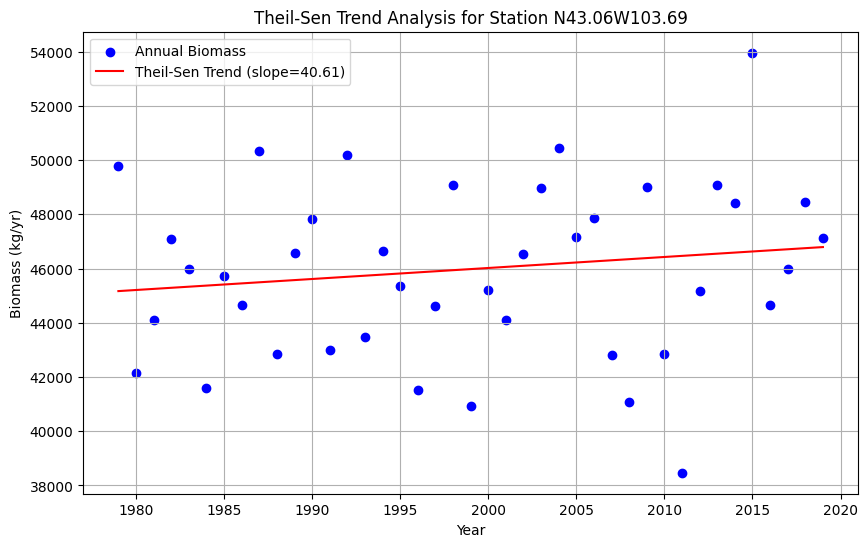

Mann-Kendall Test Result for Station N43.06W103.69:
Mann_Kendall_Test(trend='no trend', h=False, p=0.38711605416916584, z=0.8648592353998134, Tau=0.0951219512195122, s=78.0, var_s=7926.666666666667, slope=40.60941176470577, intercept=45169.17176470588)


In [70]:
# Extract the annual biomass values for the station
# Ensure the values are treated as numeric.
annual_biomass = station[year_columns].astype(float)

# Convert the series into two arrays: one for years and one for values.
years = np.array([int(col.split('_')[1]) for col in year_columns])
values = annual_biomass.values

# Compute the Theil-Sen estimator (robust trend estimate)
slope, intercept, lo_slope, up_slope = theilslopes(values, years, 0.95)
trend_line = intercept + slope * years

# Plot the data and the trend line
plt.figure(figsize=(10, 6))
plt.scatter(years, values, color='blue', label='Annual Biomass')
plt.plot(years, trend_line, color='red', label=f'Theil-Sen Trend (slope={slope:.2f})')
plt.xlabel('Year')
plt.ylabel('Biomass (kg/yr)')
plt.title(f'Theil-Sen Trend Analysis for Station {station_id}')
plt.legend()
plt.grid(True)
plt.show()

# Perform the Mann-Kendall test on the annual biomass series
mk_result = mk.original_test(values)
print(f"Mann-Kendall Test Result for Station {station_id}:")
print(mk_result)

In [12]:
# Filter for Minnesota stations using the "State Name" column
df_ca = df[df["State Name"] == "California"]
# Calculate the total biomass for each station across all years
df_ca['total_biomass'] = df_ca[year_columns].sum(axis=1)

# Select the top 20 stations with the highest total biomass
df_top20 = df_ca.sort_values('total_biomass', ascending=False).head(20)
df_top20

C:\Users\meghnasingh\AppData\Local\Temp\ipykernel_29272\854432168.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ca['total_biomass'] = df_ca[year_columns].sum(axis=1)


OBJECTID_12_13  OBJECTID      StationID      area_ha  biomass_kg_yr  \
26812           27234     27233  N32.69W115.06   709.430000   6.931324e+07   
26702           27124     27123  N32.69W115.06   121.874811   1.190750e+07   
26180           26602     26601  N32.81W115.56    72.763958   7.035018e+06   
25940           26362     26361  N33.06W115.31  1529.630000   1.454782e+08   
26182           26604     26603  N32.94W115.44   166.481318   1.582749e+07   
25196           25618     25617  N33.19W115.56  1300.001515   1.235662e+08   
26181           26603     26602  N32.94W115.56   224.894724   2.136081e+07   
26171           26593     26592  N32.94W115.19  2021.250000   1.918772e+08   
24906           25328     25327  N33.44W114.81  1337.384089   1.261413e+08   
24909           25331     25330  N33.56W114.69   109.219875   1.029794e+07   
24908           25330     25329  N33.56W114.69   211.744759   1.996464e+07   
24911           25333     25332  N33.56W114.69   167.864928   1.582737e+07   
24910           25332     25331  N33.56W114.69  1862.006148   1.755618e+08   
24102           24524     24523  N33.69W114.56   252.358598   2.365642e+07   
24805           25227     25226  N33.44W115.06   848.287657   7.942617e+07   
26701           27123     27122  N32.69W115.19   452.015189   4.211293e+07   
24907           25329     25328  N33.56W114.81  2744.448549   2.550423e+08   
24400           24822     24821  N33.56W114.81   648.040019   6.022252e+07   
24806           25228     25227  N33.44W114.94   812.312343   7.540987e+07   
24211           24633     24632  N33.69W114.69   503.810000   4.606472e+07   

       rd_yield_M_gal_yr  N_demand_T_yr  P_demand_T_yr  Jan_L_ha   Feb_L_ha  \
26812          12.665505    6378.018066     927.711731  838890.0  1090000.0   
26702           2.175840    1095.696167     159.373993  838890.0  1090000.0   
26180           1.285498     647.343445      94.159050  802186.0  1040000.0   
25940          26.583016   13386.514648    1947.129272  726824.0   941181.0   
26182           2.892134    1456.403076     211.840454  796288.0  1000000.0   
25196          22.579071   11370.231445    1653.851929  875595.0  1140000.0   
26181           3.903228    1965.563965     285.900208  845369.0  1070000.0   
26171          35.061430   17656.021484    2568.148682  797928.0  1040000.0   
24906          23.049612   11607.183594    1688.317627  891833.0  1180000.0   
24909           1.881728     947.589172     137.831146  741161.0  1030000.0   
24908           3.648109    1837.092773     267.213501  741161.0  1030000.0   
24911           2.892112    1456.392334     211.838882  741161.0  1030000.0   
24910          32.080141   16154.723633    2349.777832  741161.0  1030000.0   
24102           4.322703    2176.800537     316.625519  688020.0   989561.0   
24805          14.513426    7308.583008    1063.066650  893501.0  1190000.0   
26701           7.695233    3875.118652     563.653625  815120.0  1050000.0   
24907          46.603496   23468.306641    3413.571777  738021.0  1030000.0   
24400          11.004371    5541.514648     806.038452  738021.0  1030000.0   
24806          13.779533    6939.013672    1009.311096  880472.0  1170000.0   
24211           8.417337    4238.751465     616.545654  661110.0   950899.0   

       ...    y_2013    y_2014     y_2015    y_2016     y_2017    y_2018  \
26812  ...  97091.28  99403.44  100147.22  99314.36  100051.07  99343.68   
26702  ...  97091.28  99403.44  100147.22  99314.36  100051.07  99343.68   
26180  ...  95830.67  98384.95   99015.98  98340.35   98784.30  98332.97   
25940  ...  94883.15  96978.54   97621.93  96976.62   97166.67  96992.98   
26182  ...  94677.61  97062.18   97308.15  96945.19   96861.41  96542.08   
25196  ...  93929.54  96894.44   98316.61  97045.60   96768.74  97201.25   
26181  ...  94372.81  96378.58   97715.93  96441.56   97098.56  96920.79   
26171  ...  94072.56  97027.85   97039.62  97342.79   96591.62  97155.99   
24906  ...  92620.62  95

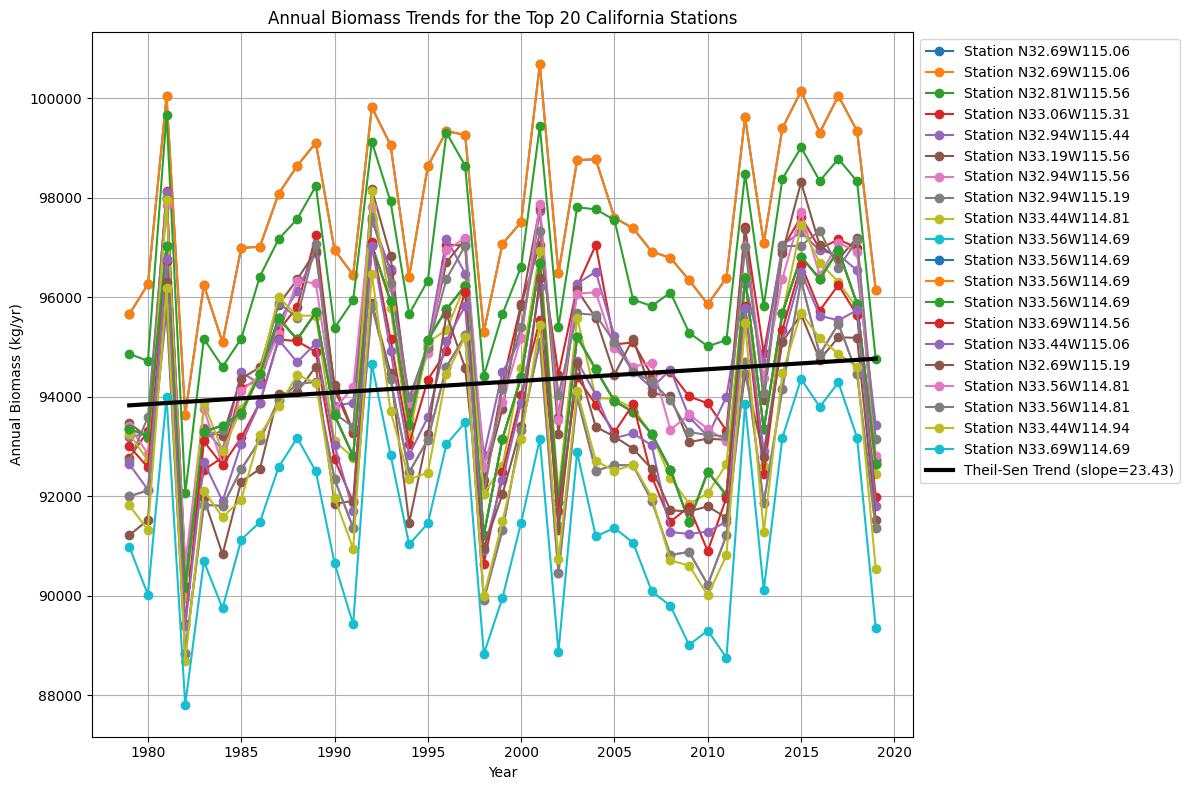

In [117]:
# Define the list of year columns based on your CSV (from 1979 to 2019)
year_columns = [f'y_{year}' for year in range(1979, 2020)]
years = np.array([year for year in range(1979, 2020)])

plt.figure(figsize=(12, 8))

# Loop through each Minnesota station and plot its annual biomass data
for idx, row in df_top20.iterrows():
    station_id = row['StationID']
    # Convert the yearly data to float (in case it's not already)
    values = row[year_columns].astype(float).values
    plt.plot(years, values, marker='o', label=f'Station {station_id}')

# Calculate the average annual biomass across all  stations
avg_biomass = df_top20[year_columns].mean(axis=0).values.astype(float)

# Compute the overall trendline using the Theil-Sen estimator on the averaged data
slope, intercept, lo_slope, up_slope = theilslopes(avg_biomass, years, 0.95)
trend_line = intercept + slope * years

# Plot the overall trendline
plt.plot(years, trend_line, color='black', linewidth=3, label=f'Theil-Sen Trend (slope={slope:.2f})')

plt.xlabel('Year')
plt.ylabel('Annual Biomass (kg/yr)')
plt.title('Annual Biomass Trends for the Top 20 California Stations')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Adjust legend placement if needed
plt.grid(True)
plt.tight_layout()
plt.show()

In [115]:
# Perform the Mann-Kendall test on the annual biomass series
biomass = df_ca[year_columns].mean(axis=0).values.astype(float)
mk_result = mk.original_test(biomass)
print(f"Mann-Kendall Test Result for California:")
print(mk_result)

Mann-Kendall Test Result for California:
Mann_Kendall_Test(trend='increasing', h=True, p=0.00776849553745107, z=2.661969334931893, Tau=0.29024390243902437, s=238.0, var_s=7926.666666666667, slope=65.52540062156197, intercept=68296.38423991496)


C:\Users\meghnasingh\AppData\Local\Temp\ipykernel_29272\381415757.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tx['total_biomass'] = df_tx[year_columns].sum(axis=1)


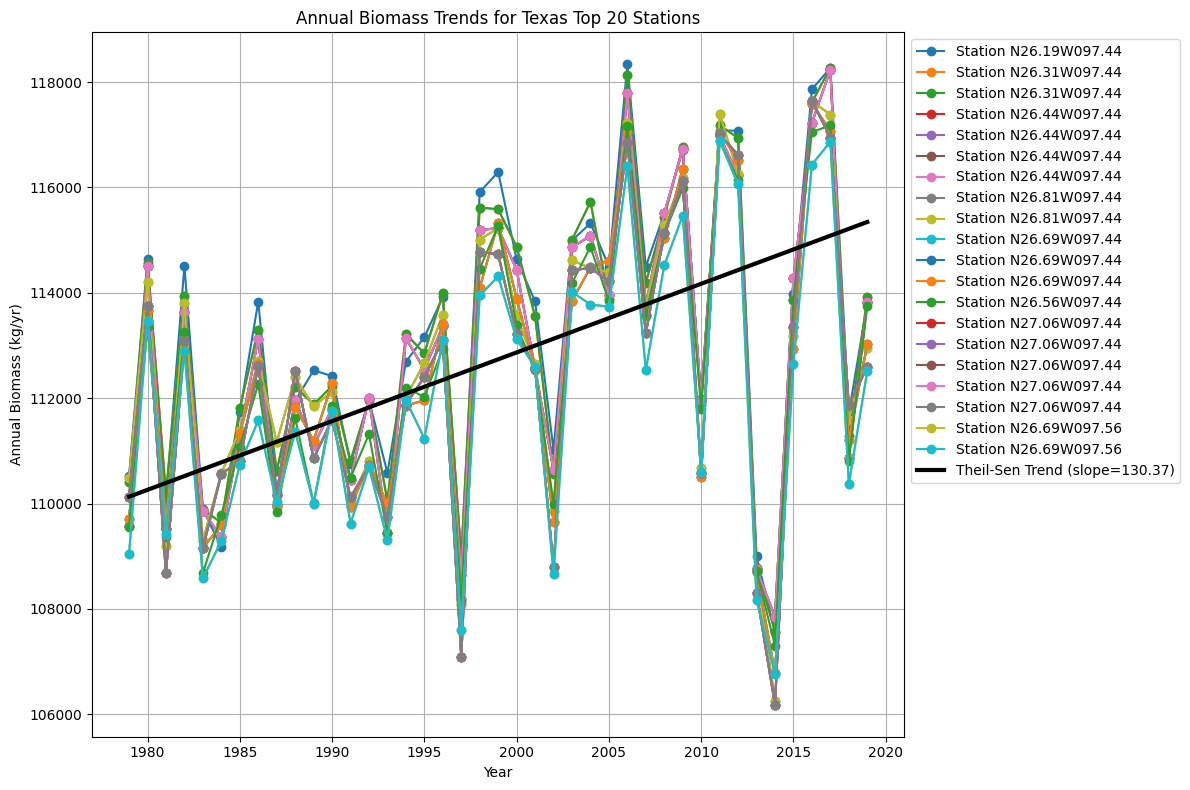

In [118]:
# Filter for Minnesota stations using the "State Name" column
df_tx = df[df["State Name"] == "Texas"]
# Calculate the total biomass for each station across all years
df_tx['total_biomass'] = df_tx[year_columns].sum(axis=1)

# Select the top 20 stations with the highest total biomass
df_txtop20 = df_tx.sort_values('total_biomass', ascending=False).head(20)

plt.figure(figsize=(12, 8))

# Loop through each Minnesota station and plot its annual biomass data
for idx, row in df_txtop20.iterrows():
    station_id = row['StationID']
    # Convert the yearly data to float (in case it's not already)
    values = row[year_columns].astype(float).values
    plt.plot(years, values, marker='o', label=f'Station {station_id}')

# Calculate the average annual biomass across all  stations
avg_biomass = df_txtop20[year_columns].mean(axis=0).values.astype(float)

# Compute the overall trendline using the Theil-Sen estimator on the averaged data
slope, intercept, lo_slope, up_slope = theilslopes(avg_biomass, years, 0.95)
trend_line = intercept + slope * years

# Plot the overall trendline
plt.plot(years, trend_line, color='black', linewidth=3, label=f'Theil-Sen Trend (slope={slope:.2f})')

plt.xlabel('Year')
plt.ylabel('Annual Biomass (kg/yr)')
plt.title('Annual Biomass Trends for Texas Top 20 Stations')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Adjust legend placement if needed
plt.grid(True)
plt.tight_layout()
plt.show()

In [32]:
# Perform the Mann-Kendall test on the annual biomass series
mk_result = mk.original_test(avg_biomass)
print(f"Mann-Kendall Test Result for Texas:")
print(mk_result)

Mann-Kendall Test Result for Texas:
Mann_Kendall_Test(trend='increasing', h=True, p=0.0025161591880287215, z=3.021391354838309, Tau=0.32926829268292684, s=270.0, var_s=7926.666666666667, slope=130.37229067460407, intercept=110129.97868650791)


In [ ]:
# Filter for Minnesota stations using the "State Name" column
df_wi = df[df["State Name"] == "Texas"]
# Calculate the total biomass for each station across all years
df_tx['total_biomass'] = df_tx[year_columns].sum(axis=1)

# Select the top 20 stations with the highest total biomass
df_txtop20 = df_tx.sort_values('total_biomass', ascending=False).head(20)

plt.figure(figsize=(12, 8))

# Loop through each Minnesota station and plot its annual biomass data
for idx, row in df_txtop20.iterrows():
    station_id = row['StationID']
    # Convert the yearly data to float (in case it's not already)
    values = row[year_columns].astype(float).values
    plt.plot(years, values, marker='o', label=f'Station {station_id}')

plt.xlabel('Year')
plt.ylabel('Annual Biomass (kg/yr)')
plt.title('Annual Biomass Trends for Texas Top 20 Stations')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Adjust legend placement if needed
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\meghnasingh\AppData\Local\Temp\ipykernel_29272\2435024327.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fl['total_biomass'] = df_fl[year_columns].sum(axis=1)


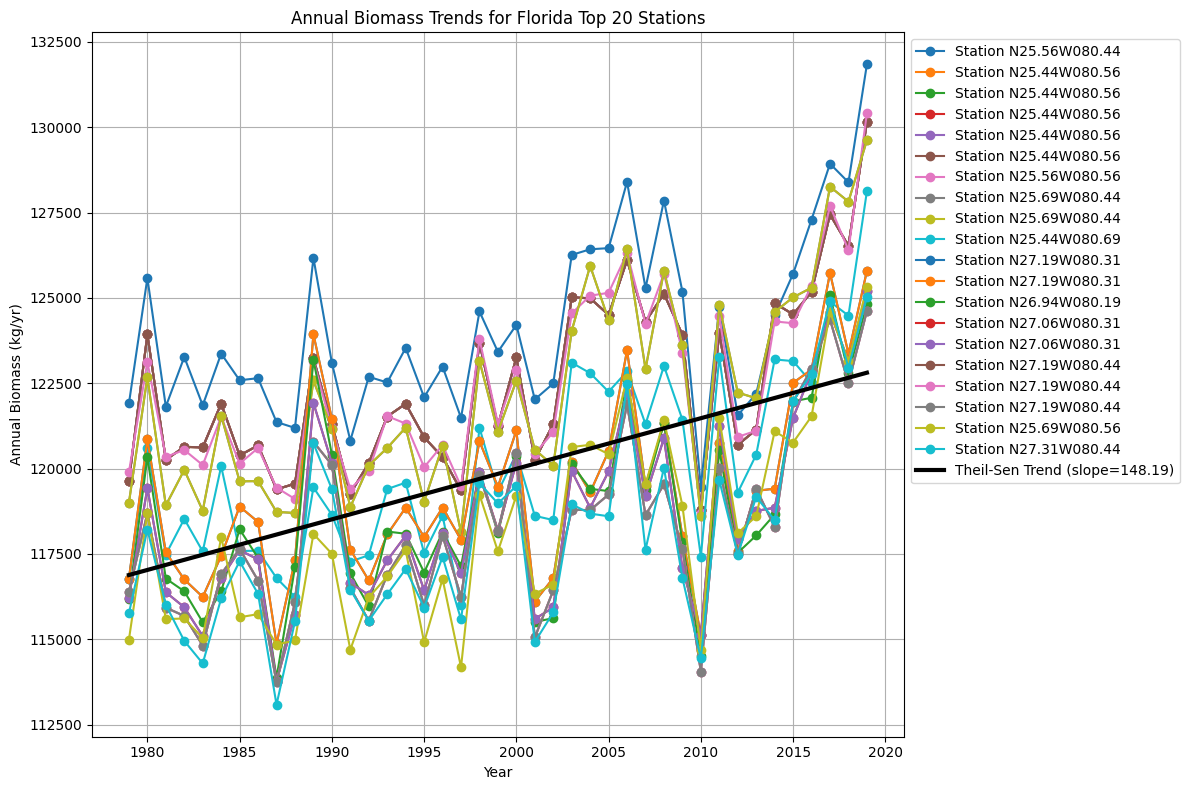

In [119]:
# Filter for Minnesota stations using the "State Name" column
df_fl = df[df["State Name"] == "Florida"]
# Calculate the total biomass for each station across all years
df_fl['total_biomass'] = df_fl[year_columns].sum(axis=1)

# Select the top 20 stations with the highest total biomass
df_fltop20 = df_fl.sort_values('total_biomass', ascending=False).head(20)

plt.figure(figsize=(12, 8))

# Loop through each Minnesota station and plot its annual biomass data
for idx, row in df_fltop20.iterrows():
    station_id = row['StationID']
    # Convert the yearly data to float (in case it's not already)
    values = row[year_columns].astype(float).values
    plt.plot(years, values, marker='o', label=f'Station {station_id}')

# Calculate the average annual biomass across all  stations
avg_biomass = df_fltop20[year_columns].mean(axis=0).values.astype(float)

# Compute the overall trendline using the Theil-Sen estimator on the averaged data
slope, intercept, lo_slope, up_slope = theilslopes(avg_biomass, years, 0.95)
trend_line = intercept + slope * years

# Plot the overall trendline
plt.plot(years, trend_line, color='black', linewidth=3, label=f'Theil-Sen Trend (slope={slope:.2f})')

plt.xlabel('Year')
plt.ylabel('Annual Biomass (kg/yr)')
plt.title('Annual Biomass Trends for Florida Top 20 Stations')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Adjust legend placement if needed
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\meghnasingh\AppData\Local\Temp\ipykernel_29272\1090748921.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nd['total_biomass'] = df_nd[year_columns].sum(axis=1)


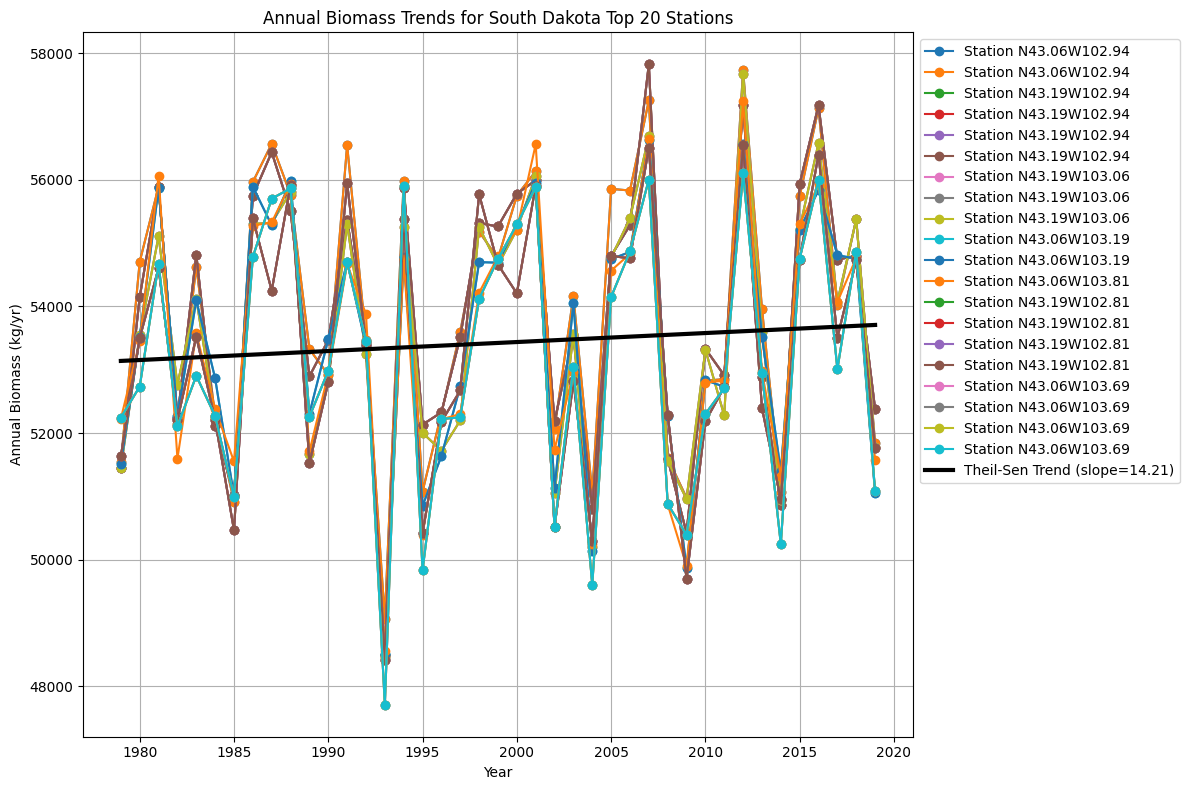

In [120]:
df_nd  = df[df["State Name"].isin(["South Dakota"])]

# Calculate the total biomass for each station across all years
df_nd['total_biomass'] = df_nd[year_columns].sum(axis=1)

# Select the top 20 stations with the highest total biomass
df_ndtop20 = df_nd.sort_values('total_biomass', ascending=False).head(20)

plt.figure(figsize=(12, 8))

# Loop through each Minnesota station and plot its annual biomass data
for idx, row in df_ndtop20.iterrows():
    station_id = row['StationID']
    # Convert the yearly data to float (in case it's not already)
    values = row[year_columns].astype(float).values
    plt.plot(years, values, marker='o', label=f'Station {station_id}')

# Calculate the average annual biomass across all stations
avg_biomass = df_ndtop20[year_columns].mean(axis=0).values.astype(float)

# Compute the overall trendline using the Theil-Sen estimator on the averaged data
slope, intercept, lo_slope, up_slope = theilslopes(avg_biomass, years, 0.95)
trend_line = intercept + slope * years

# Plot the overall trendline
plt.plot(years, trend_line, color='black', linewidth=3, label=f'Theil-Sen Trend (slope={slope:.2f})')

plt.xlabel('Year')
plt.ylabel('Annual Biomass (kg/yr)')
plt.title('Annual Biomass Trends for South Dakota Top 20 Stations')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Adjust legend placement if needed
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\meghnasingh\AppData\Local\Temp\ipykernel_29272\449100091.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nd['total_biomass'] = df_nd[year_columns].sum(axis=1)


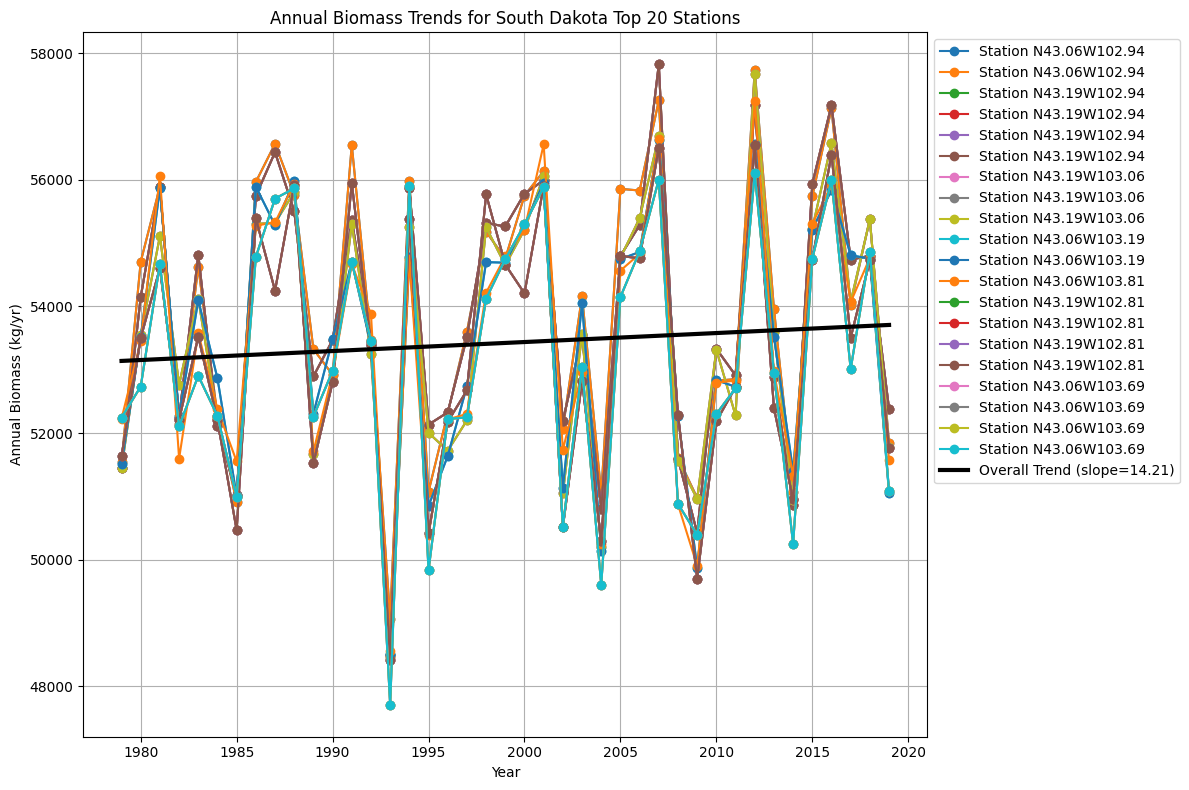

Mann-Kendall Test Result for South Dakota:
Mann_Kendall_Test(trend='no trend', h=False, p=0.7446315154396081, z=0.32572620554018944, Tau=0.036585365853658534, s=30.0, var_s=7926.666666666667, slope=14.21130128205093, intercept=53139.12147435898)


In [ ]:
# Perform the Mann-Kendall test on the annual biomass series
mk_result = mk.original_test(avg_biomass)
print(f"Mann-Kendall Test Result for South Dakota:")
print(mk_result)

In [40]:
df['total_water_use'] = df.apply(lambda x: x['Sum_L_ha']*x['area_ha'], axis=1)
df.head()

OBJECTID_12_13  OBJECTID      StationID      area_ha  biomass_kg_yr  \
0               1         1  N48.94W122.56   717.810000   3.292898e+07   
1               2         2  N48.94W122.56   305.591026   1.401875e+07   
2               3         3  N48.94W122.44  1212.268974   5.919113e+07   
3               4         4  N48.81W122.69   300.373796   1.415649e+07   
4               5         5  N48.81W122.56   838.836204   3.934977e+07   

   rd_yield_M_gal_yr  N_demand_T_yr  P_demand_T_yr  Jan_L_ha  Feb_L_ha  ...  \
0           6.017063    3030.036377     440.732544   2168.74       0.0  ...   
1           2.561626    1289.968018     187.631699   2168.74       0.0  ...   
2          10.815906    5446.608398     792.234009   2428.20       0.0  ...   
3           2.586795    1302.642456     189.475281   2341.76       0.0  ...   
4           7.190325    3620.860352     526.670593   2128.60       0.0  ...   

     y_2014    y_2015    y_2016    y_2017    y_2018    y_2019   Shape__Area  \
0  48409.60  53963.15  44652.22  45995.85  48438.89  47133.62  7.178100e+06   
1  48409.60  53963.15  44652.22  45995.85  48438.89  47133.62  3.055910e+06   
2  50862.81  57235.89  48315.91  49578.13  52795.88  52150.76  1.212269e+07   
3  48424.35  55195.31  45251.17  47238.54  49132.85  48914.92  3.003738e+06   
4  49622.38  55253.22  44837.07  46600.16  49593.89  48563.04  8.388362e+06   

   Shape__Length  Latitude  total_water_use  
0   45700.000000     48.94     1.453264e+09  
1   19681.188936     48.94     6.186935e+08  
2   89225.605536     48.94     2.627633e+09  
3   22877.648056     48.81     6.001766e+08  
4   41972.021256     48.81     1.650389e+09  

[5 rows x 586 columns]

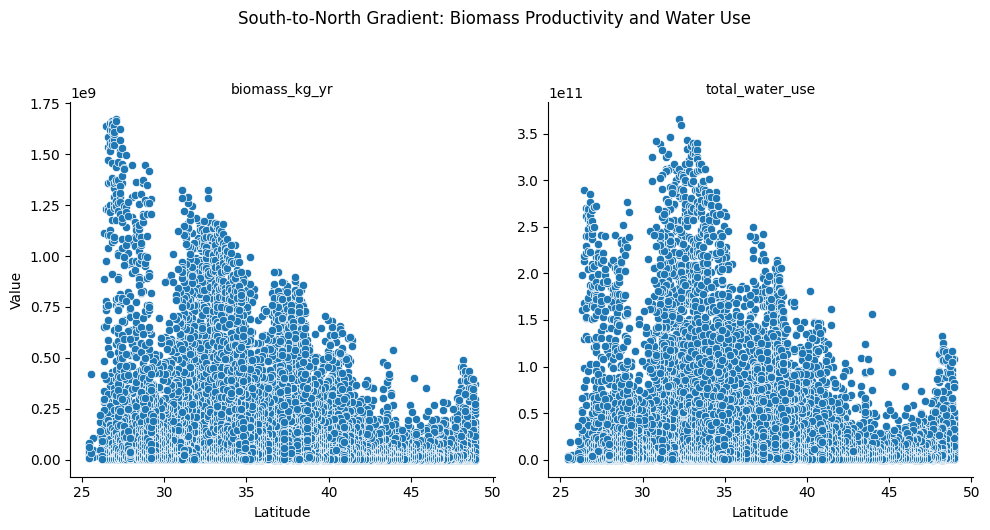

In [44]:
import seaborn as sns

# Make sure the Latitude column and the fields of interest are numeric
df['Latitude'] = pd.to_numeric(df['Latitude'], errors='coerce')
df['biomass_kg_yr'] = pd.to_numeric(df['biomass_kg_yr'], errors='coerce')
df['total_water_use'] = pd.to_numeric(df['total_water_use'], errors='coerce')

# Melt the DataFrame so that biomass and water use are in a single column
df_melt = pd.melt(df,
                  id_vars=['StationID', 'Latitude'],
                  value_vars=['biomass_kg_yr', 'total_water_use'],
                  var_name='Variable',
                  value_name='Value')

# Create a FacetGrid to plot each variable in a separate panel
g = sns.FacetGrid(df_melt, col='Variable', height=5, aspect=1, sharey=False)
g.map(sns.scatterplot, 'Latitude', 'Value')
g.set_axis_labels("Latitude", "Value")
g.set_titles("{col_name}")
plt.suptitle("South-to-North Gradient: Biomass Productivity and Water Use", y=1.05)
plt.tight_layout()
plt.show()


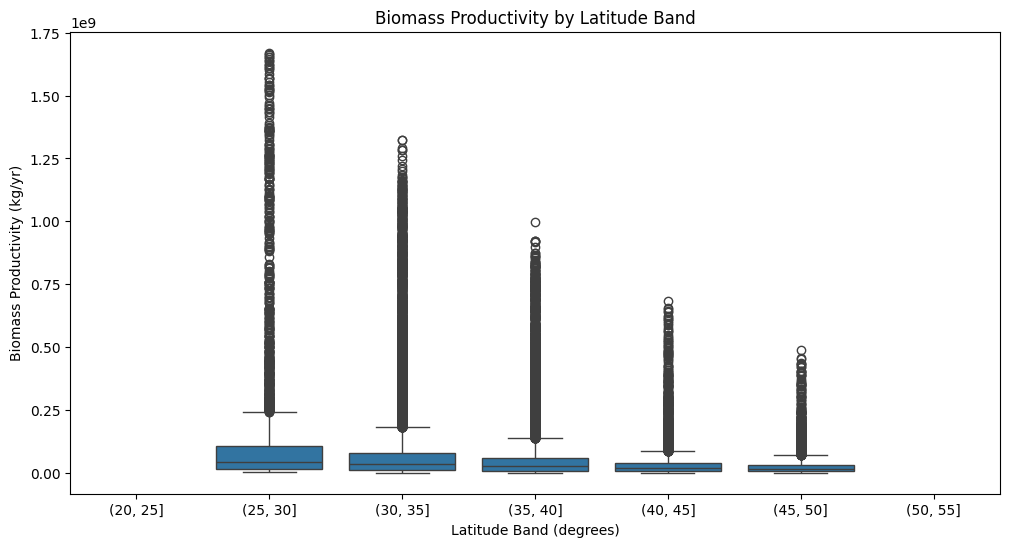

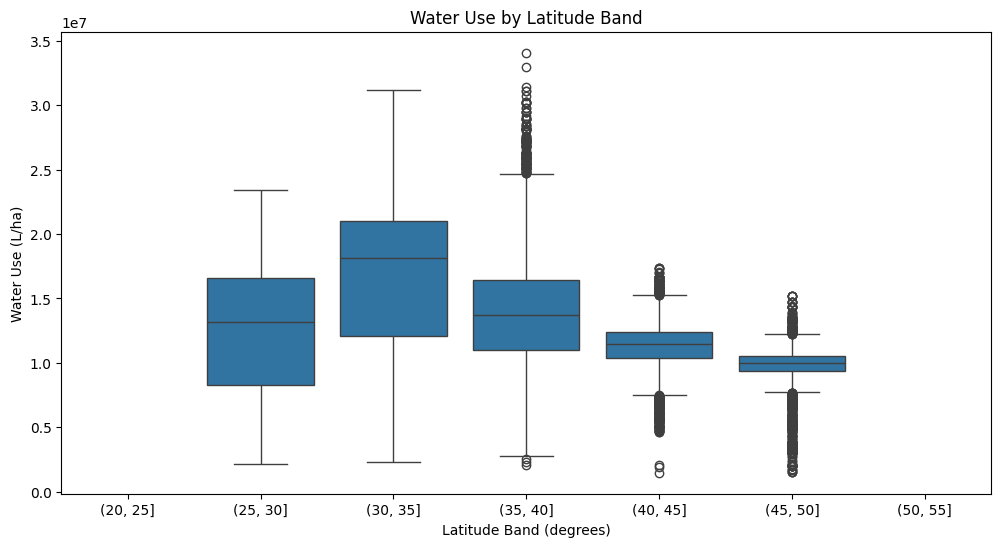

In [45]:
# Define latitude bins (for example, from 20 to 55 degrees; adjust as needed)
bins = [20, 25, 30, 35, 40, 45, 50, 55]
# Create a new column with the latitude band labels
df['lat_band'] = pd.cut(df['Latitude'], bins=bins)

# Box plot for Biomass Productivity by Latitude Band
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='lat_band', y='biomass_kg_yr')
plt.xlabel('Latitude Band (degrees)')
plt.ylabel('Biomass Productivity (kg/yr)')
plt.title('Biomass Productivity by Latitude Band')
plt.show()

# Box plot for Water Use by Latitude Band
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='lat_band', y='Sum_L_ha')
plt.xlabel('Latitude Band (degrees)')
plt.ylabel('Water Use (L/ha)')
plt.title('Water Use by Latitude Band')
plt.show()

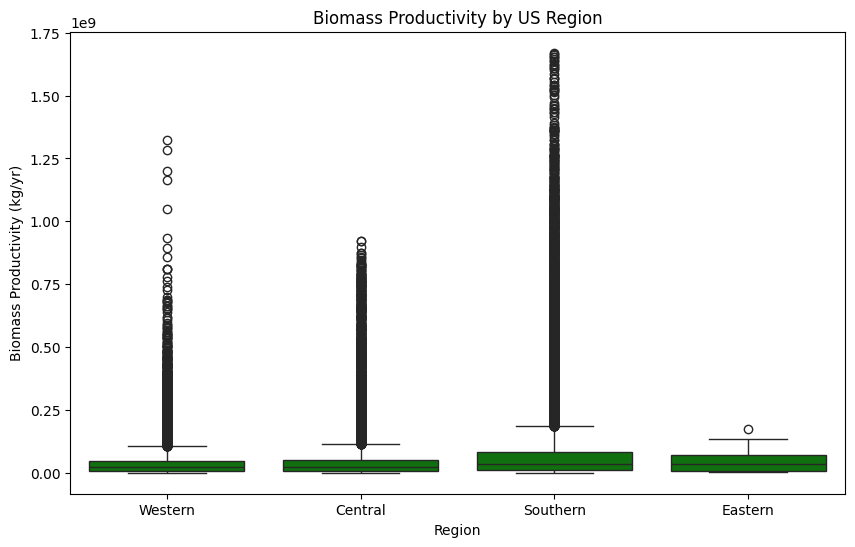

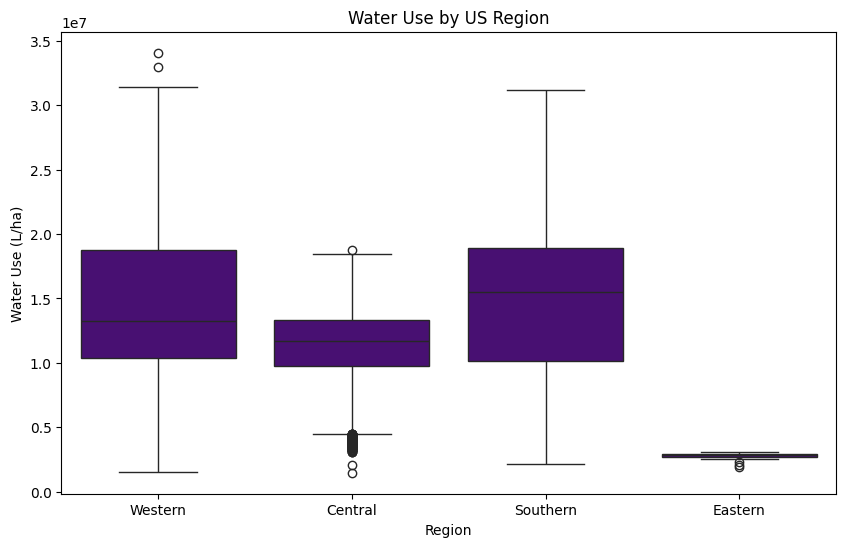

In [103]:
# Box plot for Biomass Productivity by Region
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='NWSRegion', y='biomass_kg_yr', color="green", order=["Western", "Central", "Southern", "Eastern"])
plt.xlabel('Region')
plt.ylabel('Biomass Productivity (kg/yr)')
plt.title('Biomass Productivity by US Region')
plt.show()

# Box plot for Water Use by Region
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='NWSRegion', y='Sum_L_ha', color="indigo", order=["Western", "Central", "Southern", "Eastern"])
plt.xlabel('Region')
plt.ylabel('Water Use (L/ha)')
plt.title('Water Use by US Region')
plt.show()

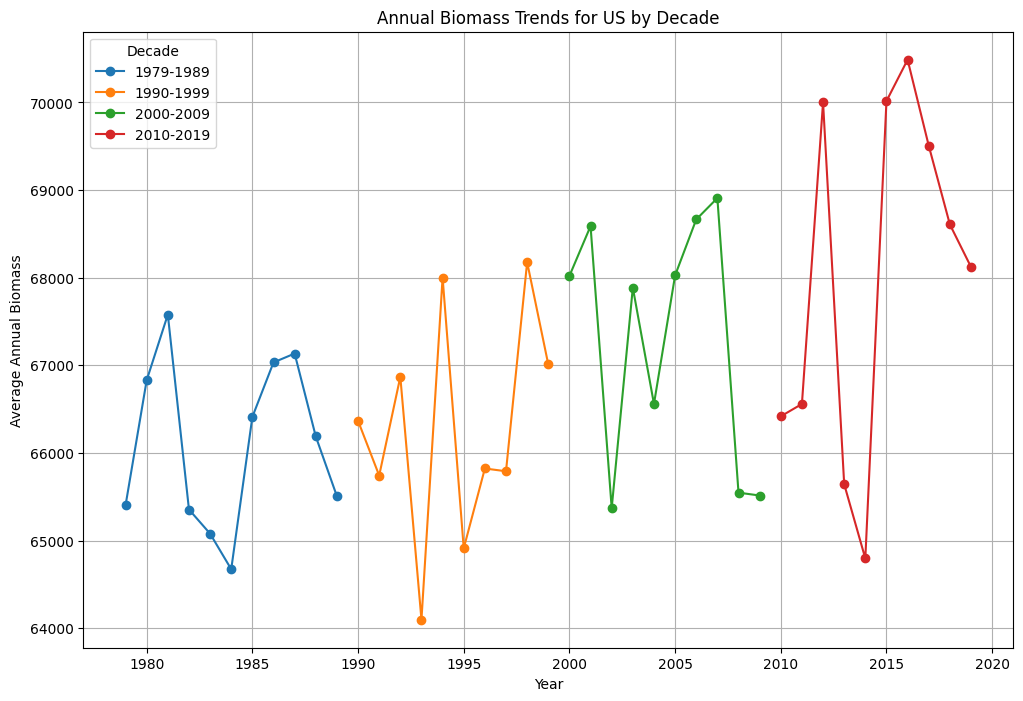

In [99]:
# -------------------------------
# Step 2. Compute Overall Annual Biomass
# -------------------------------
# Average the annual biomass across all stations for each year.
annual_results = []
for year in years:
    col = f'y_{year}'
    annual_avg = df[col].mean()  # Average biomass across stations for the given year
    annual_results.append({'Year': year, 'Annual_Biomass': annual_avg})

# Create a DataFrame for the annual results.
df_annual = pd.DataFrame(annual_results)

# -------------------------------
# Step 3. Define Decadal Periods
# -------------------------------
def assign_decade(year):
    if 1979 <= year <= 1989:
        return "1979-1989"
    elif 1990 <= year <= 1999:
        return "1990-1999"
    elif 2000 <= year <= 2009:
        return "2000-2009"
    elif 2010 <= year <= 2019:
        return "2010-2019"
    else:
        return "Other"

df_annual['Decade'] = df_annual['Year'].apply(assign_decade)

# -------------------------------
# Step 4. Visualize the Trends
# -------------------------------

# (A) Bar Chart: Average Annual Biomass by Decade
# decade_avg = df_annual.groupby('Decade')['Annual_Biomass'].mean().reset_index()
# plt.figure(figsize=(10,6))
# sns.barplot(data=decade_avg, x='Decade', y='Annual_Biomass', 
#             order=["1979-1989", "1990-1999", "2000-2009", "2010-2019"])
# plt.xlabel('Decade')
# plt.ylabel('Average Annual Biomass')
# plt.title('Average Annual Biomass by Decade')
# plt.show()

# (B) Stacked XY Plot: Annual Biomass Trends by Decade
plt.figure(figsize=(12,8))
for decade, group in df_annual.groupby('Decade'):
    plt.plot(group['Year'], group['Annual_Biomass'], marker='o', linestyle='-', label=decade)
plt.xlabel('Year')
plt.ylabel('Average Annual Biomass')
plt.title('Annual Biomass Trends for US by Decade')
plt.legend(title='Decade')
plt.grid(True)
plt.show()


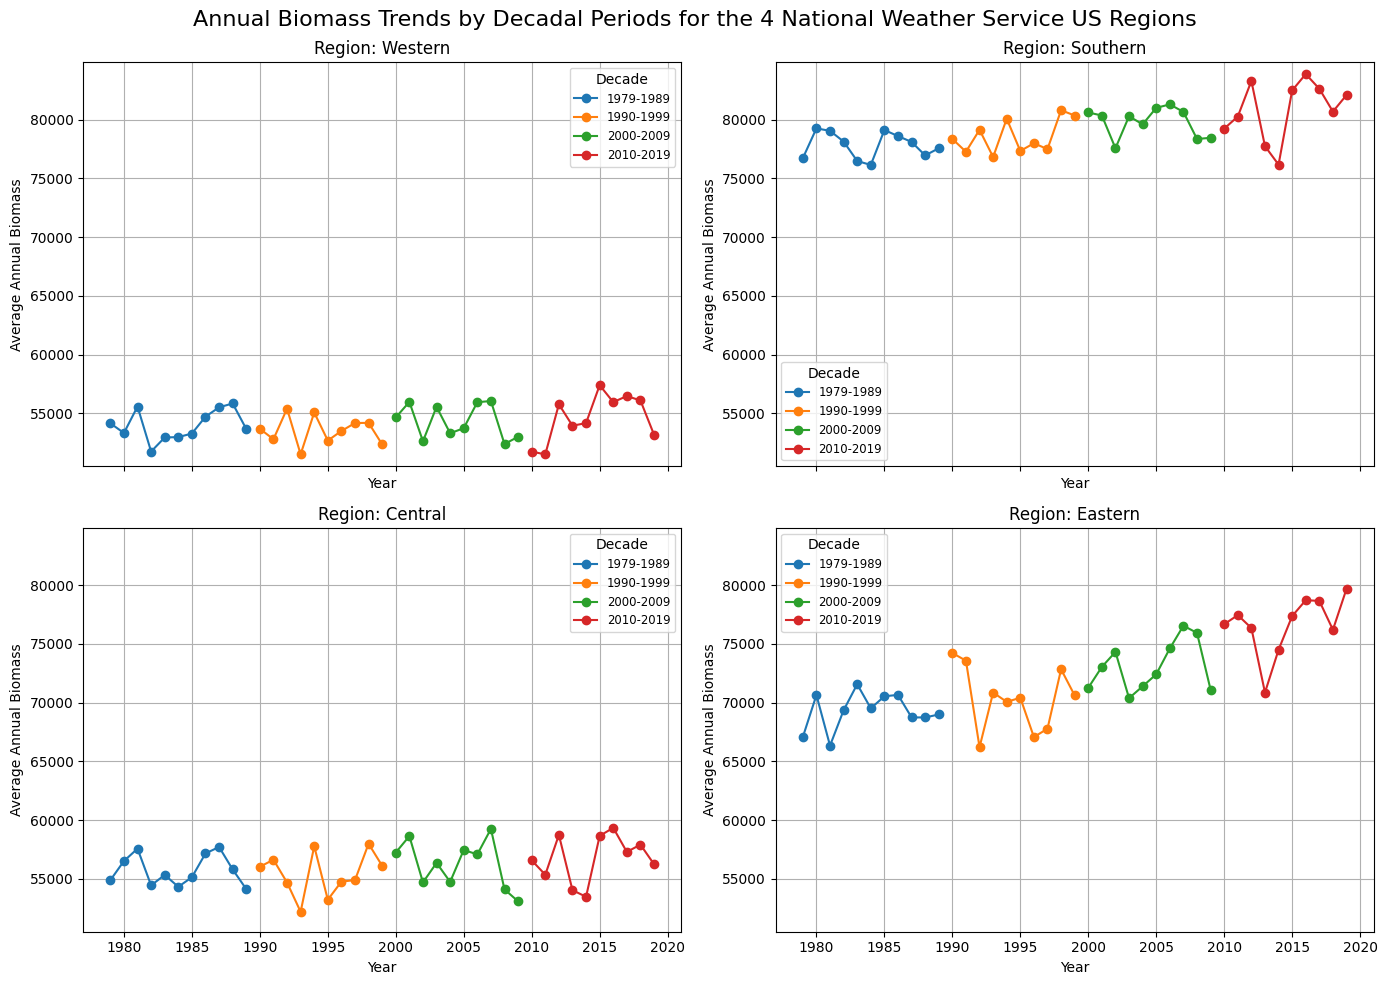

In [173]:
# For each region and for each year, compute the average biomass across stations.

data_list = []
for region in df['NWSRegion'].unique():
    df_region = df[df['NWSRegion'] == region]
    for year in years:
        col = f'y_{year}'
        avg_biomass = df_region[col].mean()
        data_list.append({'NWSRegion': region, 'Year': year, 'Annual_Biomass': avg_biomass})

df_region_year = pd.DataFrame(data_list)

df_region_year['Decade'] = df_region_year['Year'].apply(assign_decade)

# Calculate global y-axis limits for all regions for easier comparison
global_min = df_region_year['Annual_Biomass'].min()
global_max = df_region_year['Annual_Biomass'].max()

# --- Step 6: Create a Stacked XY Plot for the 4 Regions by Decadal Periods ---
regions_order = ["Western", "Southern", "Central", "Eastern"]

fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True)
axes = axes.flatten()

for i, region in enumerate(regions_order):
    ax = axes[i]
    # Filter data for this region
    region_data = df_region_year[df_region_year['NWSRegion'] == region]
    
    # Plot a line for each decadal period within this region
    for dec, group in region_data.groupby('Decade'):
        ax.plot(group['Year'], group['Annual_Biomass'], marker='o', linestyle='-', label=dec)
    
    ax.set_title(f'Region: {region}')
    ax.set_xlabel('Year')
    ax.set_ylabel('Average Annual Biomass')
    ax.set_ylim(global_min-1000, global_max+1000)
    ax.legend(title='Decade', fontsize='small')
    ax.grid(True)

fig.suptitle('Annual Biomass Trends by Decadal Periods for the 4 National Weather Service US Regions', fontsize=16)
plt.tight_layout()#rect=[0, 0, 1, 0.95])
plt.show()


In [60]:
bbox_states = [
    "Montana",
    "North Dakota",
    "South Dakota",
    "Wyoming",
    "Nebraska",
    "Colorado",
    "Kansas",
    "Oklahoma",
    "New Mexico",
    "Texas",
    "Missouri",
    "Iowa",
    "Minnesota",
    "Arkansas",
    "Louisiana"
]

# Filter the DataFrame to include only rows (stations) within the bounding-box states
df_bbox = df[df["State Name"].isin(bbox_states)]


C:\Users\meghnasingh\AppData\Local\Temp\ipykernel_29272\2046582567.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bbox[col] = pd.to_numeric(df_bbox[col], errors='coerce')
C:\Users\meghnasingh\AppData\Local\Temp\ipykernel_29272\2046582567.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bbox["mean_biomass"] = df_bbox[[f"y_{year}" for year in years]].mean(axis=1)


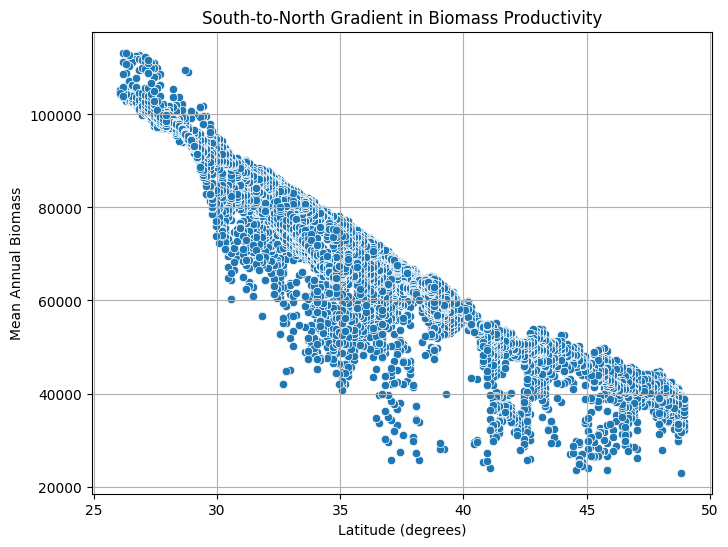

In [63]:
years = list(range(1979, 2020))  # adjust if needed
for year in years:
    col = f'y_{year}'
    df_bbox[col] = pd.to_numeric(df_bbox[col], errors='coerce')

# Compute mean annual biomass across all years for each station
df_bbox["mean_biomass"] = df_bbox[[f"y_{year}" for year in years]].mean(axis=1)

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_bbox, x="Latitude", y="mean_biomass")
plt.title("South-to-North Gradient in Biomass Productivity")
plt.xlabel("Latitude (degrees)")
plt.ylabel("Mean Annual Biomass")
plt.grid(True)
plt.show()

<Axes: xlabel='Latitude', ylabel='mean_biomass'>

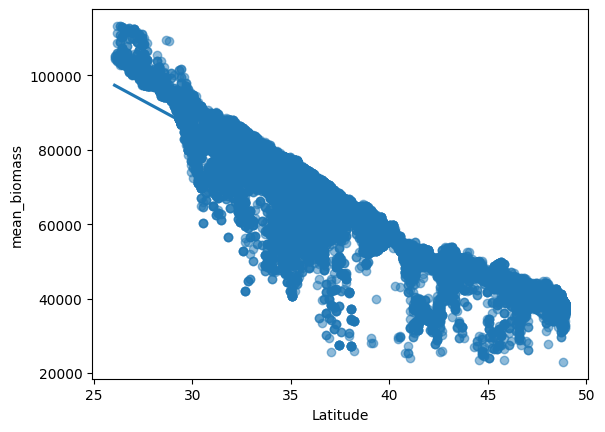

In [64]:
#sns.regplot(data=df_bbox, x="Latitude", y="mean_biomass", ci=None, scatter_kws={'alpha':0.5})
years = list(range(1979, 2020))  # adjust if needed
for year in years:
    col = f'y_{year}'
    df_bbox[col] = pd.to_numeric(df_bbox[col], errors='coerce')

# Compute mean annual biomass across all years for each station
df_bbox["mean_biomass"] = df_bbox[[f"y_{year}" for year in years]].mean(axis=1)

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_bbox, x="Latitude", y="mean_biomass")
plt.title("South-to-North Gradient in Biomass Productivity")
plt.xlabel("Latitude (degrees)")
plt.ylabel("Mean Annual Biomass")
plt.grid(True)
plt.show()

C:\Users\meghnasingh\AppData\Local\Temp\ipykernel_29272\522106452.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bbox["lat_band"] = pd.cut(df_bbox["Latitude"], bins=range(25, 51, 2))  # example bins from 25° to 50°


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, '(25, 27]'),
  Text(1, 0, '(27, 29]'),
  Text(2, 0, '(29, 31]'),
  Text(3, 0, '(31, 33]'),
  Text(4, 0, '(33, 35]'),
  Text(5, 0, '(35, 37]'),
  Text(6, 0, '(37, 39]'),
  Text(7, 0, '(39, 41]'),
  Text(8, 0, '(41, 43]'),
  Text(9, 0, '(43, 45]'),
  Text(10, 0, '(45, 47]'),
  Text(11, 0, '(47, 49]')])

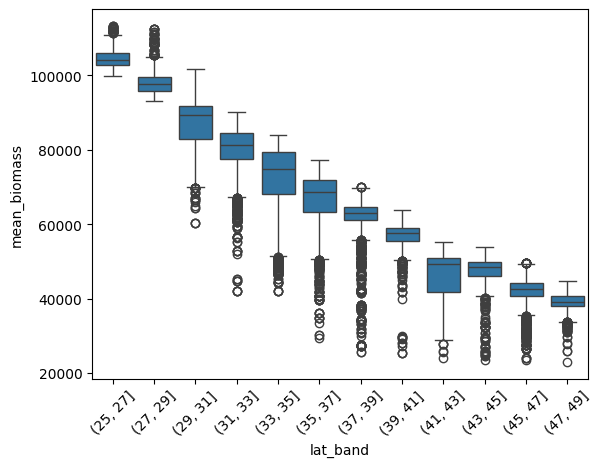

In [65]:
df_bbox["lat_band"] = pd.cut(df_bbox["Latitude"], bins=range(25, 51, 2))  # example bins from 25° to 50°
sns.boxplot(data=df_bbox, x="lat_band", y="mean_biomass")
plt.xticks(rotation=45)


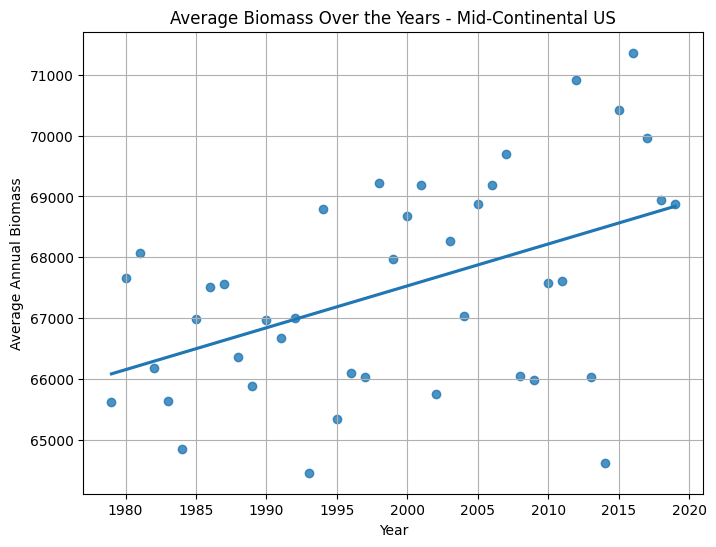

In [89]:
annual_avg_list = []
for year in years:
    col = f'y_{year}'
    # Average across all stations in the bounding box
    annual_avg = df_bbox[col].mean()
    annual_avg_list.append([year, annual_avg])

df_annual = pd.DataFrame(annual_avg_list)
df_annual.columns = ['Year','AvgBiomass']

# 4. Plot the time series with a trendline
plt.figure(figsize=(8, 6))
sns.regplot(data=df_annual, x='Year', y='AvgBiomass', marker='o', ci=None)
plt.title('Average Biomass Over the Years - Mid-Continental US')
plt.xlabel('Year')
plt.ylabel('Average Annual Biomass')
plt.grid(True)
plt.show()

In [91]:
mk_result = mk.original_test(df_annual['AvgBiomass'])
print(f"Mann-Kendall Test Result for Mid-Continental US")
print(mk_result)

Mann-Kendall Test Result for Mid-Continental US
Mann_Kendall_Test(trend='increasing', h=True, p=0.004487646216817742, z=2.841680344885101, Tau=0.3097560975609756, s=254.0, var_s=7926.666666666667, slope=72.38130587602029, intercept=66063.66342678027)


In [136]:
temp = pd.read_csv('nws_region_temp.csv')
# Extract the Year from the "Date" column which is in the format YYYYMM
temp['Year'] = temp['Date'].astype(str).str[:4].astype(int)
temp['Month'] = temp['Date'].astype(str).str[-2:].astype(int)
temp['Decade'] = temp['Year'].apply(assign_decade)
temp = temp[temp['Decade'] != 'Other']
temp.head()

Date  Temperature   Region  Year  Month     Decade
0  197907         70.5  Western  1979      7  1979-1989
1  198007         70.8  Western  1980      7  1979-1989
2  198107         70.3  Western  1981      7  1979-1989
3  198207         68.6  Western  1982      7  1979-1989
4  198307         68.1  Western  1983      7  1979-1989

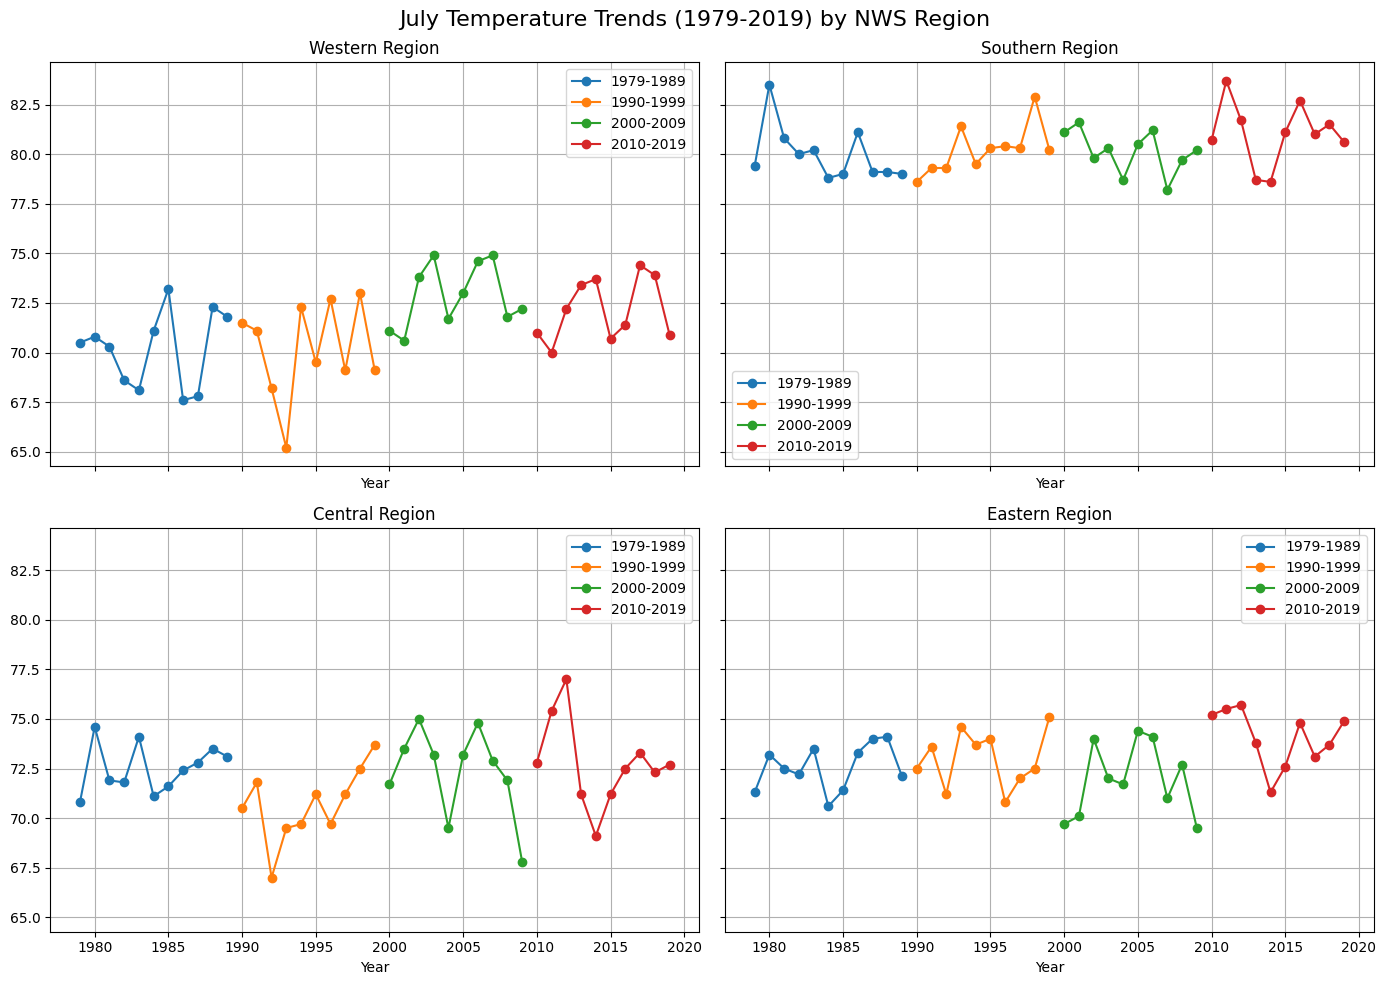

In [172]:
# Define the four NWS regions in the desired order
regions_order = ["Western", "Southern", "Central", "Eastern"]

# Create a 2x2 grid of subplots (share x- and y-axis for biomass)
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)
axes = axes.flatten()

for i, region in enumerate(regions_order):
    ax = axes[i]

    region_temp = temp[temp['Region'] == region].sort_values('Year')

    # Plot a line for each decadal period within this region
    for dec, group in region_temp.groupby('Decade'):
        ax.plot(group['Year'], group['Temperature'], marker='o', linestyle='-', label=dec)
    
    # Plot total biomass (primary y-axis)
    # line1, = ax.plot(region_temp['Year'], region_temp['Temperature'], 
    #                   marker='o', label='July Temperature')
    # ax.set_ylabel('July Temperature (°C)')
    # ax.tick_params(axis='y')
    # #ax.set_ylim(biomass_min, biomass_max)
    
    ax.set_title(f"{region} Region")
    ax.set_xlabel("Year")
    
    # Combine legends from both axes
    #lines = [line1]
    #labels = [l.get_label() for l in lines]
    ax.legend()#lines, labels, loc='upper left')
    ax.grid(True)

fig.suptitle("July Temperature Trends (1979-2019) by NWS Region", fontsize=16)
plt.tight_layout()#rect=[0, 0.03, 1, 0.95])
plt.show()


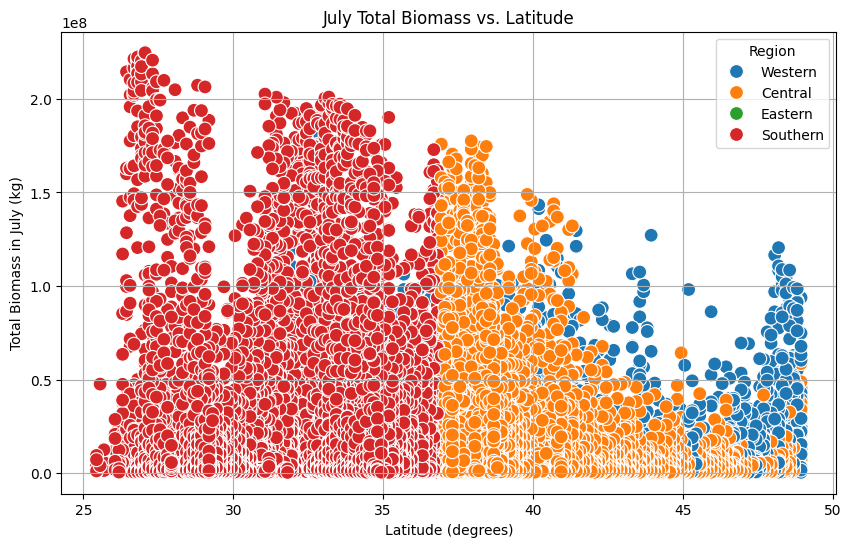

In [164]:
# Compute total biomass for July (assumes MeanJul_kg_ha_mo_ is the average per hectare)
df['TotalBiomass_Jul'] = df['MeanJul_kg_ha_mo_'] * df['area_ha']

# Create a scatter plot: Latitude on x-axis, TotalBiomass_Jul on y-axis, colored by Region
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x="Latitude", y="TotalBiomass_Jul", hue="NWSRegion", s=100)
plt.title("July Total Biomass vs. Latitude")
plt.xlabel("Latitude (degrees)")
plt.ylabel("Total Biomass in July (kg)")
plt.grid(True)
plt.legend(title="Region")
plt.show()


In [171]:
df['TotalBiomass_Jul'] = df['MeanJul_kg_ha_mo_'] * df['area_ha']

# Define the four NWS regions in the desired order
regions_order = ["Western", "Southern", "Central", "Eastern"]

# Create a 2x2 grid of subplots (share x- and y-axis for biomass)
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)
axes = axes.flatten()

# Determine global y-axis limits for TotalBiomass_Jul across all regions for easier comparison
biomass_min = df['MeanJul_kg_ha_mo_'].min()
biomass_max = df['MeanJul_kg_ha_mo_'].max()

for i, region in enumerate(regions_order):
    ax = axes[i]

    region_data = df[df['NWSRegion'] == region].sort_values('Latitude')
    sns.scatterplot(data=region_data, x="Latitude", y="MeanJul_kg_ha_mo_", hue="State Name", s=40, ax=ax)
 
    ax.set_title(f"{region} Region")
    ax.set_xlabel("Latitude (°)")
    ax.set_ylabel("Mean July Biomass (kg)")
    ax.set_ylim(biomass_min-1000, biomass_max+1000)
    ax.grid(True)

fig.suptitle("Average monthly Biomass Production for July from 1979-2019", fontsize=16)
plt.tight_layout()#rect=[0, 0.03, 1, 0.95])
plt.show()

In [152]:
df.Longitude.min(), df.Longitude.max()


(-124.31, -75.44)

In [159]:
#bins = [-125, -115, -105, -95, -85, -75]
# Create a new column with the latitude band labels
#df['longitude'] = pd.cut(df['Longitude'], bins=bins)
df.drop(columns='longitude', inplace=True)